In [1]:
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import pandas as pd
import proplot as pplt
from scipy.fftpack import * 

2021.08.08

尝试使用proplot绘制平均图

使用pre_process/merge_cmorph_cn051.ipynb 下合并掉cmorph以及cmorph的数据·

In [2]:
dir_in = "/raid52/yycheng/MPAS/REFERENCE/TEMP_DATA_large/pre/ordata/"
filename_obs  = "obsmerge_pre_98-17.nc"
filename_vr     = "vr_pre_98-17.nc"
filename_rcm    = "rcm_pre_98-17.nc"

ds_or = {}
ds_or['obs'] = xr.open_dataset(dir_in + filename_obs)
ds_or['vr']     = xr.open_dataset(dir_in + filename_vr)
ds_or['rcm']    = xr.open_dataset(dir_in + filename_rcm  )
# 提取变量
var = {}
var['obs'] = ds_or['obs']['premerge']#[:,  :, :]
var['vr'] = ds_or['vr']['precip_MPAS']
var['rcm'] = ds_or['rcm']['precip_MPAS']

var['obs'] = var['obs'].reset_coords(names = 'lev', drop = True) # 去除掉obs中多余的lev coords

# change coords
var_list = ['obs', 'vr', 'rcm']
for i in var_list:
    rename_dict = dict(zip(var[i].coords.keys(), var['obs'].coords.keys()))
#     # show converting coords
    for rename_i in rename_dict:
        print(rename_i + " -----converting to----- " + rename_dict[rename_i])

    var[i] = var[i].rename(rename_dict)
    var[i]._coords = var['obs']._coords
    var[i] = var[i].rename(i)


time -----converting to----- time
lon -----converting to----- lon
lat -----converting to----- lat
Time -----converting to----- time
longitude -----converting to----- lon
latitude -----converting to----- lat
Time -----converting to----- time
longitude -----converting to----- lon
latitude -----converting to----- lat


In [3]:
var_selmonth = {}
var_selmonth['am'] = {}
var_selmonth['jja'] = {}

time_idx_am = var['obs'].time.dt.month.isin([4,5])
time_idx_jja = var['obs'].time.dt.month.isin([6,7,8])

for mod_name in ['obs', 'vr', 'rcm']:
    var_selmonth['am'][mod_name]  = var[mod_name].isel(time = time_idx_am).mean(dim = 'time')
    var_selmonth['jja'][mod_name] = var[mod_name].isel(time = time_idx_jja).mean(dim = 'time')

## 绘图部分

In [4]:
# 下面网址得到的降水cmap
# https://unidata.github.io/python-gallery/examples/Precipitation_Map.html

cmap_data = [(1.0, 1.0, 1.0),
             (0.3137255012989044, 0.8156862854957581, 0.8156862854957581),
             (0.0, 1.0, 1.0),
             (0.0, 0.8784313797950745, 0.501960813999176),
             (0.0, 0.7529411911964417, 0.0),
             (0.501960813999176, 0.8784313797950745, 0.0),
             (1.0, 1.0, 0.0),
             (1.0, 0.6274510025978088, 0.0),
             (1.0, 0.0, 0.0),
             (1.0, 0.125490203499794, 0.501960813999176),
             (0.9411764740943909, 0.250980406999588, 1.0),
             (0.501960813999176, 0.125490203499794, 1.0),
             (0.250980406999588, 0.250980406999588, 1.0),
             (0.125490203499794, 0.125490203499794, 0.501960813999176),
             (0.125490203499794, 0.125490203499794, 0.125490203499794),
             (0.501960813999176, 0.501960813999176, 0.501960813999176),
             (0.8784313797950745, 0.8784313797950745, 0.8784313797950745),
             (0.9333333373069763, 0.8313725590705872, 0.7372549176216125),
             (0.8549019694328308, 0.6509804129600525, 0.47058823704719543),
             (0.6274510025978088, 0.42352941632270813, 0.23529411852359772),
             (0.4000000059604645, 0.20000000298023224, 0.0)]

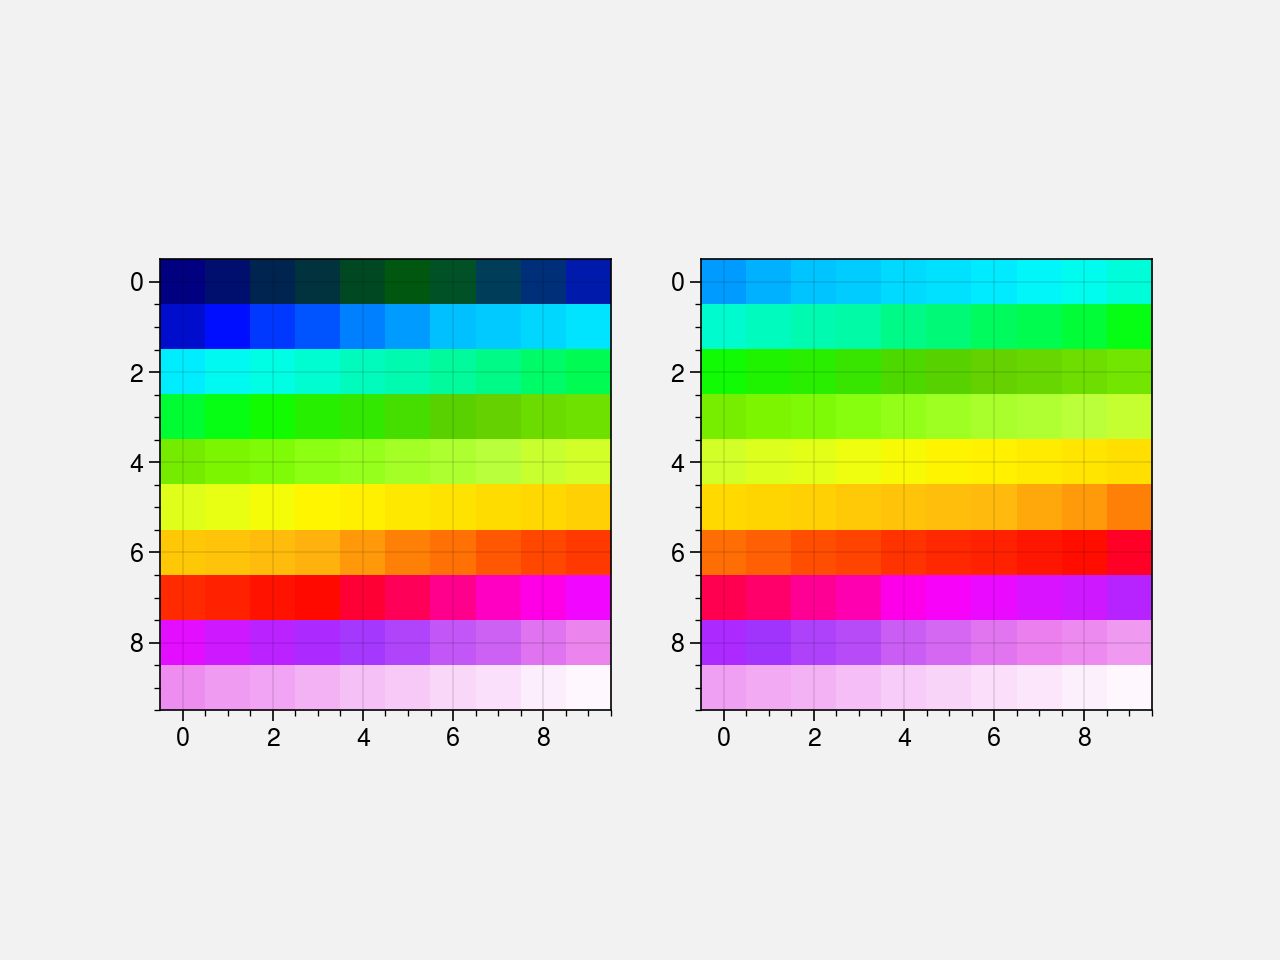

In [5]:
# 调整cmap，去掉gist_ncar 中深蓝色的部分
# https://stackoverflow.com/questions/18926031/how-to-extract-a-subset-of-a-colormap-as-a-new-colormap-in-matplotlib

import matplotlib.pyplot as plt
import matplotlib.colors as colors
import numpy as np

def truncate_colormap(cmap, minval=0.0, maxval=1.0, n=100):
    new_cmap = colors.LinearSegmentedColormap.from_list(
        'trunc({n},{a:.2f},{b:.2f})'.format(n=cmap.name, a=minval, b=maxval),
        cmap(np.linspace(minval, maxval, n)))
    return new_cmap

arr = np.linspace(0, 50, 100).reshape((10, 10))
fig, ax = plt.subplots(ncols=2)

cmap = plt.get_cmap('gist_ncar')
new_cmap = truncate_colormap(cmap, 0.15, 1.)
ax[0].imshow(arr, interpolation='nearest', cmap=cmap)
ax[1].imshow(arr, interpolation='nearest', cmap=new_cmap)
plt.show()

In [6]:
# 国内政区图的绘制
# Load the border data, CN-border-La.dat is download from
# https://gmt-china.org/data/CN-border-La.dat
import cartopy.crs as ccrs
import cartopy.io.shapereader as shpreader
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.patches as mpatches

cn_border_file = "/m2data2/yycheng/data_stage/CN-border/CN-border_line/CN-border-La.dat"
with open(cn_border_file) as src:
    context = src.read()
    blocks = [cnt for cnt in context.split('>') if len(cnt) > 0]
    borders = [np.fromstring(block, dtype=float, sep=' ') for block in blocks]


### 画图renew
#### 2021.08.08
cn_border_file + shapefile ，但是存在重叠，尝试消除掉China边界，但是其他邻国边界无法处理；
#### 2021.08.09
不使用cn_border_file ，使用shapefile + coast_line（proplot自带） 的办法
shapefile有一些重叠，不绘制行政区
shapefile重新进行绘制，考虑来自 domain_info 中测试的多个shape file中挑选出地资所（改变了prj方式，具体查看prj后缀文件）进行使用

----- tick levels is : [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 14. 18. 22. 26. 30.
 34.]


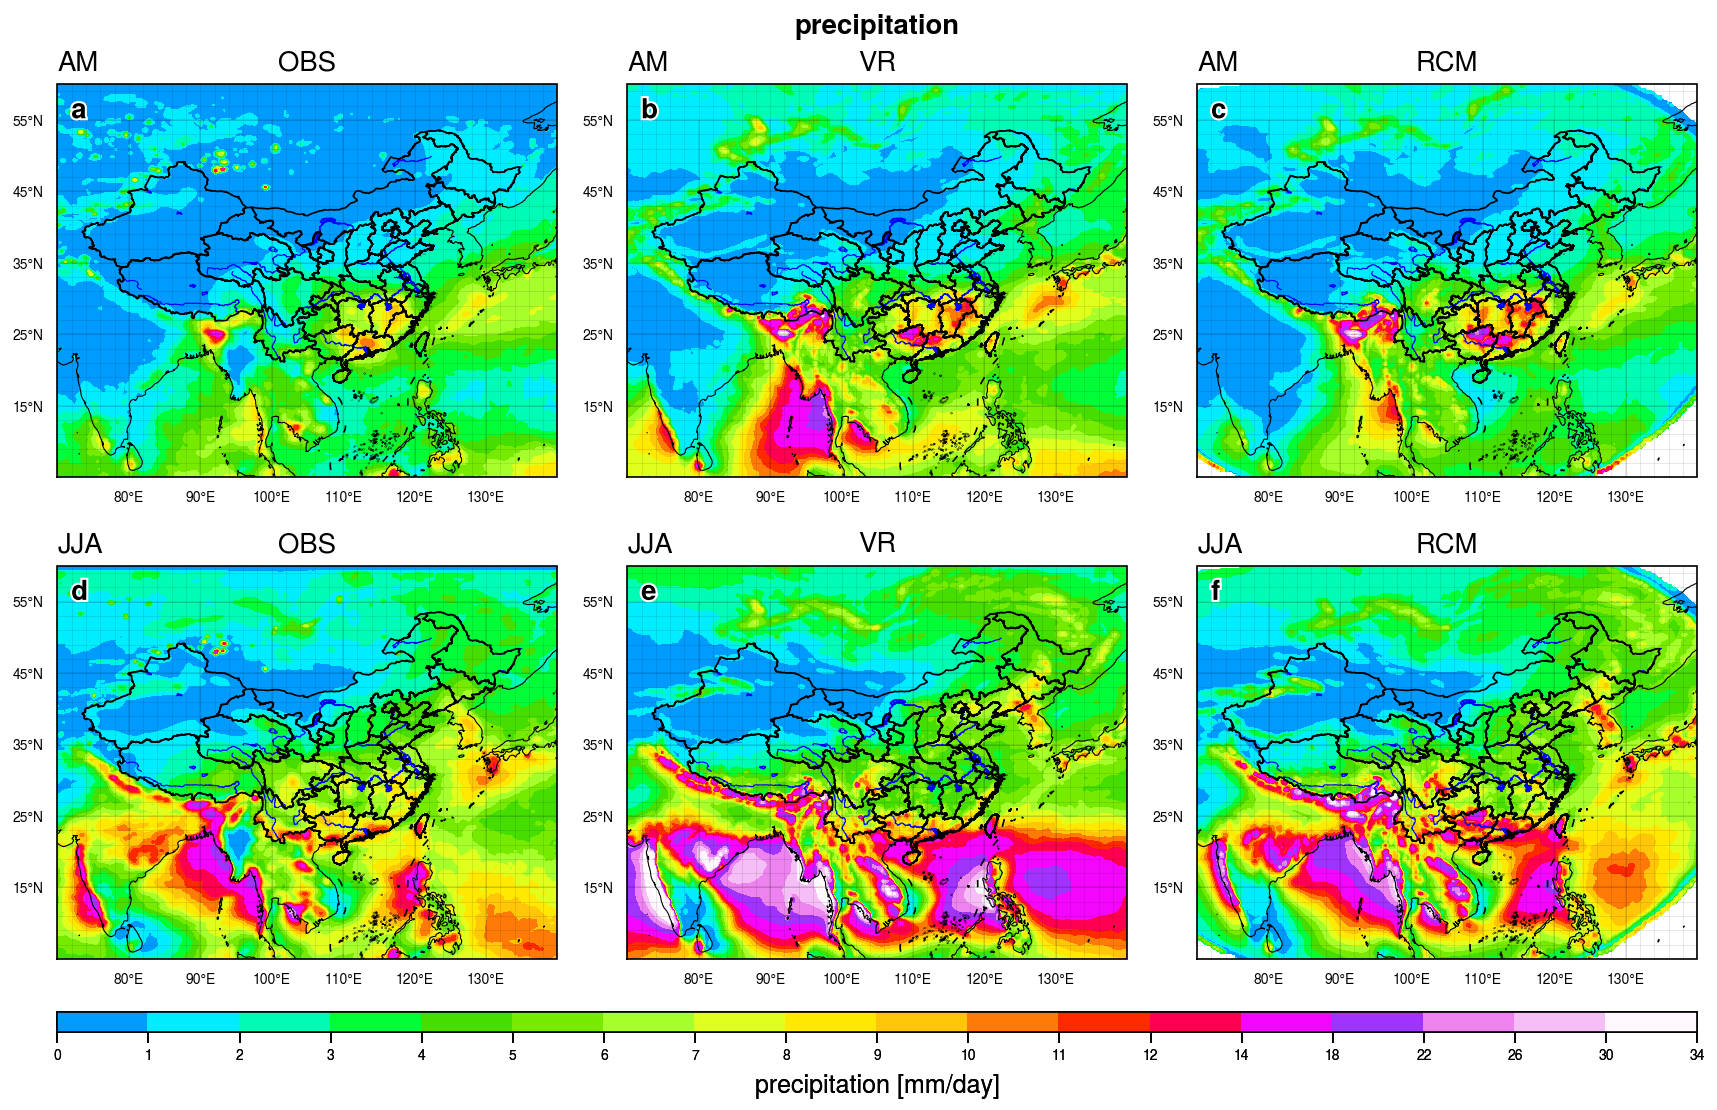

In [7]:
# import proplot as plot
from matplotlib import pyplot as plt
import proplot as plot
# ----- get filter vars coords-----

lon = var_selmonth['am']['vr'].lon.values
lat = var_selmonth['am']['vr'].lat.values

#----- create plot -----
fig, axs = plot.subplots(ncols=3 ,nrows=2, proj=('cyl'))
m_contour_list = [] # 用于保存contour设置，后续设置colorbar使用

#----- 添加海洋以及行政区划 -----
##---- 直接绘图，从边界文件添加
# for ax_ind in axs:
# for line in borders:
    # axs.plot(line[0::100], line[1::100], lw = 0.5, color='gray',transform=ccrs.Geodetic())
    # axs.plot(line[0::10], line[1::10], lw = 0.4, color='black',transform=ccrs.Geodetic())
##---- 使用shp文件添加
    ## shapefile数据下载的位置：
## http://gaohr.win/site/blogs/2017/2017-04-18-GIS-basic-data-of-China.html
# world_border_shapefile = "/m2data2/yycheng/data_stage/CN-border/World/country.shp"
river_border_shapefile =  "/raid52/yycheng/MPAS/REFERENCE/MODEL_CONSTANT/R1/" + "hyd1_4l.shp"
southsea_shapefile     = "/m2data2/yycheng/data_stage/CN-border/SouthSea/" + "southsea_island.shp"
ninelines_shapefile     = "/m2data2/yycheng/data_stage/CN-border/SouthSea/" + "nine_lines.shp"
## 来源： 沛沛的诸省 + 诸岛
bou24p_shapefile     = "/m2data2/yycheng/data_stage/CN-border/peipeihelp/" + "bou2_4p.shp"
## 来源： https://www.resdc.cn/data.aspx?DATAID=200
province_shapefile     = "/m2data2/yycheng/data_stage/CN-border/CN-sheng/" + "change_proj_CN-sheng-A.shp"

for ax in axs:
    # world     = shpreader.Reader(world_border_shapefile).geometries()
    river     = shpreader.Reader(river_border_shapefile).geometries()
    # bou24p    = shpreader.Reader(bou24p_shapefile).geometries()
    ninelines = shpreader.Reader(ninelines_shapefile).geometries()
    province  = shpreader.Reader(province_shapefile).geometries()
    ax.add_geometries(river, ccrs.PlateCarree(), facecolor='none', edgecolor='b', linewidth=0.4, zorder=1)
    # ax.add_geometries(world, ccrs.PlateCarree(), facecolor='none', edgecolor='k', linewidth=0.4, zorder=1)
    # ax.add_geometries(bou24p, ccrs.PlateCarree(), facecolor='none', edgecolor='k', linewidth=0.6, zorder=1) # 沛沛map
    ax.add_geometries(province, ccrs.PlateCarree(), facecolor='none', edgecolor='k', linewidth=0.6, zorder=1) # 地资所
    ax.add_geometries(ninelines, ccrs.PlateCarree(), facecolor='none', edgecolor='k', linewidth=0.6, zorder=1)

#----- colorbar ticks 统一设置 -----
# cmap = 'gist_ncar'
cmap = new_cmap
# cmap = cmap_data

mean_ticks = np.concatenate((np.linspace(0,12,13), np.linspace(14,34,6)), axis=0)
print("----- tick levels is : " + str(mean_ticks))

# plot contourf and titile axs
axs[0:3].format(ltitle = 'AM')
axs[3:6].format(ltitle = 'JJA')
axs[0].format(title='OBS')
axs[3].format(title='OBS')
axs[1].format(title='VR')
axs[4].format(title='VR')
axs[2].format(title='RCM')
axs[5].format(title='RCM')

for mod_ind, mod_name in enumerate(['obs','vr','rcm']):
    m_mean = axs[mod_ind].contourf(lon, lat, var_selmonth['am'][mod_name].values,\
    levels=mean_ticks,cmap=cmap)

    m_mean = axs[mod_ind+3].contourf(lon, lat, var_selmonth['jja'][mod_name].values,\
    levels=mean_ticks,cmap=cmap)


#----- add color bar-----
# fig.colorbar(m_overlay, loc='b', cmap=cmap, width=0.1)

fig.colorbar(m_mean, loc='b', width=0.1,
ticklabelsize=5,ticks=mean_ticks, title='precipitation [mm/day]')

# axs[0].colorbar(m_mean, loc='b', width=0.1,
# ticklabelsize=5,ticks=mean_ticks)

# axs[1].colorbar(m_idctn, loc='b', width=0.1,
# ticklabelsize=5,ticks=idctn_ticks)

# axs[2].colorbar(m_idctn_diff, loc='b',width=0.1,
# ticklabelsize=5,ticks=diff_ticks)


# ----- format setting -----
axs.format(
abc=True,
abcloc = 'ul',
#----- 地图底图设置 -----
# reso = 'x-hi',
reso = 'med',
# coast = False,
coast = True,
coastlinewidth = 0.4,
borders = False,
lakes = False,
land  = False,
ocean = False,
# cartopyautoextent = True, 
# borderslinewidth=.5,
labels = True,
longrid  = True,
latgrid  = True,
#-----GEO axis-----
lonlim=(70, 140), latlim=(5, 60),
gridlabelsize = 5,
gridminor = True,
lonlocator = np.arange(70,142,10),
latlocator = np.arange(5,60+2,10),
lonminorlocator = np.arange(70,140+2,2),
latminorlocator = np.arange(5,60+2,2),
#-----line label-----
# linewidth = 0.5,
# suptitle="3000km-2000km bandpass 500hPa height(1998-06 timemean)",
suptitle="precipitation",
)

#----- save figure -----
fig.patch.set_facecolor('white')
# plt.savefig('./output_pic/pre_98-17_pplt.png', dpi=500, facecolor= "white")
# plt.savefig('./output_pic/hgt_idctn.png', dpi=300, facecolor= "white")